In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, multivariate_normal

from kdelearn.kde import KDE
from kdelearn.cutils import gaussian, uniform, epanechnikov, cauchy
from kdelearn.kde_tasks import KDEClassification, KDEOutliersDetection, KDEClustering
from kdelearn.metrics import accuracy_loo, pi_kf, density_silhouette

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib

matplotlib.rcParams["mathtext.fontset"] = "cm"  # computer modern (latex default style)
matplotlib.rcParams["font.family"] = "STIXGeneral"

# Estymator jądrowy

$$\hat{f}(x) = \sum_{i=1}^m w_{i} \prod_{j=1}^n \frac{1}{h_j} K \left( \frac{x_{j} - x_{i, j}}{h_j} \right) \text{,} \quad x \in \mathbb{R}^n$$

* $m$ - liczność zbioru
* $n$ - wymiarowość
* $\mathbf{w}$ - wagi wszystkich elementów zbioru
* $K(x)$ - funkcja jądrowa
* $\mathbf{h}$ - parametr wygładzania

## Wagi

W szczególności $w_i = \frac{1}{m}$

## Funkcje jądrowe

1.&emsp;Normalne
$$K(x) = \frac{1}{\sqrt{2 \pi}} \exp \left( \frac{x^2}{2} \right)$$

2.&emsp;Jednostajne
$$K(x) = 0.5 \quad \text{gdy } |x| \leq 1 \quad \text{w przeciwnym wypadku } 0$$

3.&emsp;Epanecznikowa
$$K(x) = \frac{3}{4} (1-x^2) \quad \text{gdy } |x| \leq 1 \quad  \text{w przeciwnym wypadku } 0$$

4.&emsp;Cauchy'ego
$$K(x) = \frac{2}{\pi (x^2 + 1)^2}$$

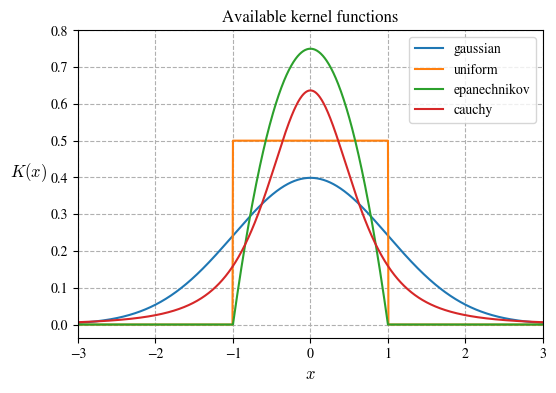

In [4]:
x_grid = np.linspace(-3, 3, 1000)

plt.figure(figsize=(6, 4), dpi=100)

for kernel in [gaussian, uniform, epanechnikov, cauchy]:
    scores = [kernel(x) for x in x_grid]
    plt.plot(x_grid, scores, label=kernel.__name__)

# # Zmiana legendy na potrzeby rozprawy
# for kernel, kname in [[gaussian, "normalne"], [uniform, "jednorodne"],
#                       [epanechnikov, "epanechnikowa"], [cauchy, "cauchy'ego"]]:
#     scores = [kernel(x) for x in x_grid]
#     plt.plot(x_grid, scores, label=kname)

plt.title("Available kernel functions")
plt.legend()
plt.xlim(-3, 3)
plt.ylim(top=0.8)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$K(x)$", rotation=0, labelpad=16, fontsize=12)
plt.grid(linestyle="--")
# plt.savefig("../docs/images/kernels.png", dpi=200)
# plt.savefig("kernels.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Komentarz do sekcji 1.2

Komentarz PK:

$\color{blue}{\text{Jądro normalne ma wszystkie pochodne w całej dziedzinie}}$ \
$\color{blue}{\text{Jądro Cauchyego całkę w całej dziedzinie}}$ \
$\color{blue}{\text{W jednostajnym najłatwiej wyznaczyć maksimum (musi być na brzegu/rogu jednego z jąder)}}$ \
$\color{blue}{\text{Jądro Epanechnikowa jest optymalne w sensie błędu L2}}$

\newpage

## Przykład konstrukcji estymatora

Przykład konstrukcji estymatora jądrowego dla ustalonych punktów przy: \
$n = 1$, $m=9$, jądro normalne, $w_i=\frac{1}{m}$, $h=0.7$

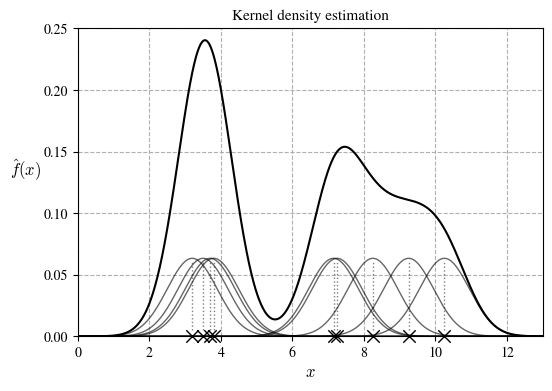

In [5]:
bandwidth = np.array([0.7])

x1, x2, x3, x4, x5, x6, x7, x8, x9 = 3.2, 3.5, 3.7, 3.8, 7.15, 7.25, 8.25, 9.25, 10.25
x_train = np.array([x1, x2, x3, x4, x5, x6, x7, x8, x9])[:, None]
m_train = x_train.shape[0]
x_grid = np.linspace(0, 13, 1000)[:, None]

plt.figure(figsize=(6, 4), dpi=100)

for x_i in x_train:
    scores = [1 / (m_train * bandwidth[0]) * gaussian((x - x_i) / bandwidth[0]) for x in x_grid]
    plt.plot(x_grid, scores, c="k", linewidth=1, alpha=0.6)
scores = KDE().fit(x_train, bandwidth=bandwidth).pdf(x_grid)
plt.plot(x_grid, scores, c="k")
plt.scatter(x_train, x_train*0, s=80, marker="x", c="k", clip_on=False, linewidth=1)
for i in range(m_train):
    plt.axvline(x_train[i], ymin=0.02, ymax=0.24, color="k", linewidth=1, linestyle=":", alpha=0.5)

plt.title("Kernel density estimation", fontsize=11)
plt.xlim(0, 13)
plt.ylim(0, 0.25)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$\hat{f}(x)$", rotation=0, labelpad=13, fontsize=12)
plt.grid(linestyle="--")
# plt.savefig("../docs/images/kde_construction.png", dpi=200)
# plt.savefig("kde_construction.pdf", format="pdf", bbox_inches="tight")
plt.show()

\newpage

Przykład konstrukcji estymatora jądrowego dla ustalonych punktów o różnych wagach przy: \
$n = 1$, $m=9$, jądro normalne, $h=0.7$

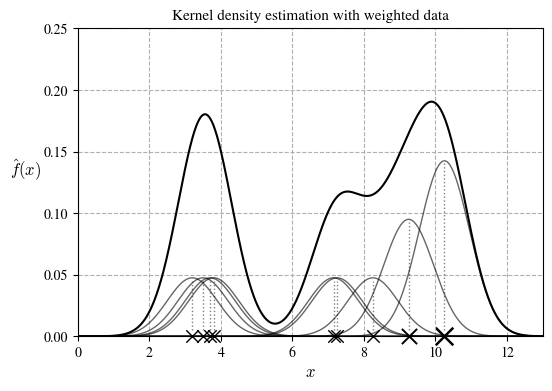

In [6]:
bandwidth = np.array([0.7])

x1, x2, x3, x4, x5, x6, x7, x8, x9 = 3.2, 3.5, 3.7, 3.8, 7.15, 7.25, 8.25, 9.25, 10.25
x_train = np.array([x1, x2, x3, x4, x5, x6, x7, x8, x9])[:, None]
weights_train = np.array([1, 1, 1, 1, 1, 1, 1, 2, 3])
weights_train = weights_train / weights_train.sum()
m_train = x_train.shape[0]
x_grid = np.linspace(0, 13, 1000)[:, None]

plt.figure(figsize=(6, 4), dpi=100)

for i, x_i in enumerate(x_train):
    scores = [weights_train[i] / bandwidth[0] * gaussian((x - x_i) / bandwidth[0]) for x in x_grid]
    plt.plot(x_grid, scores, c="k", linewidth=1, alpha=0.6)
scores = KDE().fit(x_train, weights_train=weights_train, bandwidth=bandwidth).pdf(x_grid)
plt.plot(x_grid, scores, c="k")
plt.scatter(x_train[:-2], x_train[:-2]*0, s=80, marker="x", c="k", clip_on=False, linewidth=1)
plt.scatter(x_train[-2:-1], x_train[-2:-1]*0, s=120, marker="x", c="k", clip_on=False, linewidth=1.4)
plt.scatter(x_train[-1:], x_train[-1:]*0, s=160, marker="x", c="k", clip_on=False, linewidth=1.8)

for i in range(m_train - 2):
    plt.axvline(x_train[i], ymin=0.02, ymax=0.18, color="k", linewidth=1, linestyle=":", alpha=0.5)
plt.axvline(x_train[-2], ymin=0.02, ymax=0.37, color="k", linewidth=1, linestyle=":", alpha=0.5)
plt.axvline(x_train[-1], ymin=0.02, ymax=0.57, color="k", linewidth=1, linestyle=":", alpha=0.5)

plt.title("Kernel density estimation with weighted data", fontsize=11)
plt.xlim(0, 13)
plt.ylim(0, 0.25)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$\hat{f}(x)$", rotation=0, labelpad=13, fontsize=12)
plt.grid(linestyle="--")
# plt.savefig("../docs/images/kde_construction_weighted.png", dpi=200)
# plt.savefig("kde_construction_weighted.pdf", format="pdf", bbox_inches="tight")
plt.show()

\newpage

## Parametr wygładzania

Nasze metody wyznaczania parametru wygładzania: \
1.&emsp;Metoda przybliżona (normal reference) \
2.&emsp;Metoda podstawień (direct plug-in) \
3.&emsp;Metoda podstawień (solve-the-equation plug-in - Sheather and Jones) \
4.&emsp;Metoda największej wiarygodności (likelihood cross-validation)

Kilka innych znanych metod (niezaimplementowanych):

* &emsp;Least squares cross-validation
* &emsp;Biased cross-validation
* &emsp;Solve-the-equation plug-in: Park and Marron Plug-In

W wyniku minimalizacji wartości scałkowanego błędu średniokwadratowego **MISE** mamy:
$$h_{AMISE} = \left( \frac{W(K)}{U(K)^2 Z(f) m} \right)^{\frac{1}{5}}$$ \
$$U(K) = \int_{-\infty}^{\infty} x^2 K(x) \,dx$$ \
$$W(K) = \int_{-\infty}^{\infty} K(x)^2 \,dx$$ \
$$Z(f) = \int_{-\infty}^{\infty} f''(x)^2 \,dx$$

Wskazane metody polegają na wyznaczeniu przybliżonej wartości funkocjnału $Z(f)$, gdyż niemożliwe jest jego wyliczenie wprost (nie znamy funkcji $f$).

| Typ jądra | $U(K)$ | $W(K)$ |
| --------- | ------ | ------ |
| Normalne | $1$ | $\frac{1}{2 \sqrt{\pi}}$ |
| Jednostajne | $\frac{1}{3}$ | $\frac{1}{2}$ |
| Epanecznikowa | $\frac{1}{5}$ | $\frac{3}{5}$ |
| Cauchy'ego | $1$ | $\frac{5}{4 \pi}$ |

**Uogólniona postać optymalnego $h$ dla przypadku wielowymiarowego:**
$$h_{AMISE} = \left( \frac{n W(K)}{U(K)^2 Z(f) m} \right)^{\frac{1}{n + 4}}$$

\newpage

### Metoda przybliżona (normal reference)

Podstawiamy arbistralnie wartość funkcjonału otrzymaną dla standardowego rozkładu normalnego:
$$Z(f) = \frac{3}{8\sqrt{\pi} \hat{\sigma}_j^5}$$

gdzie estymator odchylenia standardowego dany jest wzorem:
$$\hat{\sigma}_j = \sqrt{\frac{\sum_{i=1}^m (x_{i,j}-\mu_j)^2}{m-1}}$$

Komentarz ogólny:

Otrzymana za pomocą przedstawionej tu metody przybliżonej wartość parametru wygładzania jest tym użyteczniejsza, im bardziej estymowany rozkład jest zbliżony do normalnego lub ogólnie - trywialnego rozkładu unimodalnego. Najczęściej nie są to jednak sytuacje, w których warto stosować estymację nieparametrczyną. W praktyce metodę tę należy proponować przede wszystkim jako proste rozwiązanie tymczasowe, w początkowej fazie prac nad programem komputerowym, podczas wstępnej weryfikacji jego poprawności. Jest ona również używana jako pierwsze oszacowanie na potrzby bardziej złożonych procedur. (Kulczycki, P. Estymatory jądrowe w analizie systemowej, str. 79-80)


**Uogólniona postać dla przypadku wielowymiarowego:**

$$Z(f) = \frac{n(n+2)}{2^{n+2} \pi^{0.5n} \hat{\sigma}_j^5}$$

\newpage

### Metoda podstawień (direct plugin)

**Metoda podstawień ma złożoność kwadratową !!!**

Stosowana jedynie do zagadnień jednowymiarowych, a także w przypadku zmiennej wielowymiarowej, gdy używane jest jądro produktowe - wtedy algorytm obliczeniowy stosuje się $n$-krotnie, odrębnie dla poszczególnych wspołrzędnych.

Ponieważ w zależności $Z(f)$ jako funkcja podcałkowa występuje druga pochodna funkcji gęstości, więc w pierwszym kroku metody podstawień konstruowany jest
estymator jądrowy owej drugiej pochodnej $f''$. Aby z kolei wyznaczyć analogicznie wartość parametru wygładzania dla tego estymatora, w drugim kroku konstruuje się estymator jądrowy czwartej pochodnej funkcji $f^{(4)}$. Po wykonaniu $k$ takich kroków, prowadzących do wyznaczenia estymatora jądrowego funkcji $f^{(2k)}$, w celu ostatecznego zakończenia procedury oblicza się wartość jego parametru wygładzania za pomocą opisanej wcześniej metody przybliżonej. (Kulczycki, P. Estymatory jądrowe w analizie systemowej, str. 80-83)

Komentarz ogólny:

- Sekcja 3.6.1 w książce (Wand, M. P. and Jones, M. C. Kernel Smoothing, 1995).
- Implementacja zgodna z procedurą opisana w książce na stronach 80-83
- Aktualna implementacja obsługuje tylko jądro normalne (chodzi o pochodne jądra wykorzystywane przy wyliczaniu $Z(f)$) i tylko dla rzędu 0, 1, 2 i 3

### Metoda podstawień (solve-the-equation plugin)

Sekcja 3.6.2 w książce (Wand, M. P. and Jones, M. C. Kernel Smoothing, 1995).

Pomocnicze źródła:

* Turlach, Bandwidth Selection in Kernel Density Estimation: A Review, strona 28)
* Sheather, S. J., Jones, M. C., A Reliable Data-Based Bandwidth Selection Method for Kernel Density Estimation

### Metoda największej wiarygodności (likelihood cross-validation)

Sekcja 3.4.4 w książce (Silverman, B. W. Density Estimation for Statistics and Data Analysis. Chapman and Hall, 1986).

\newpage

### Przykład 1

Przykład estymatora jądrowego dla danych wygenerowanych ze standardowego rozkładu normalnego przy: \
$seed=0$, $n=1$, $m=100$, $w_i=\frac{1}{m}$, jądro normalne

h dla przybliżonej: [0.42714954]
h dla podstawień (direct) (rząd: 2):[0.45200117]
h dla podstawień (direct) (rząd: 3):[0.45093682]


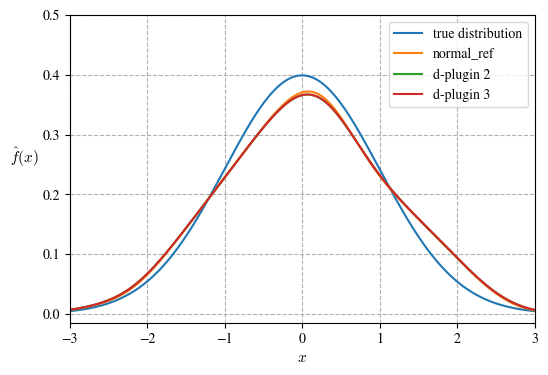

In [8]:
np.random.seed(0)

m_train = 100
n = 1
x_train = np.random.normal(0, 1, size=(m_train, n))
x_grid = np.linspace(-3, 3, 1000)[:, None]


plt.figure(figsize=(6, 4), dpi=100)

true_dist = norm.pdf(x_grid)
plt.plot(x_grid, true_dist, label="true distribution")

kde = KDE().fit(x_train, bandwidth_method="normal_reference")
scores = kde.pdf(x_grid)
plt.plot(x_grid, scores, label="normal_ref")
print(f"h dla przybliżonej: {kde.bandwidth}")

for i in range(2, 4):
    kde = KDE().fit(x_train, bandwidth_method="direct_plugin", stage=i)
    scores = kde.pdf(x_grid)
    plt.plot(x_grid, scores, label=f"d-plugin {i}")
    print(f"h dla podstawień (direct) (rząd: {i}):{kde.bandwidth}")

# kde = KDE().fit(x_train, bandwidth_method="ste_plugin")
# scores = kde.pdf(x_grid)
# plt.plot(x_grid, scores, label="ste-plugin")
# print(f"h dla podstawień (solve-the-equation): {kde.bandwidth}")

# kde = KDE().fit(x_train, bandwidth_method="ml_cv")
# scores = kde.pdf(x_grid)
# plt.plot(x_grid, scores, label="ml-cv")
# print(f"h dla największej wiarygodności: {kde.bandwidth}")

plt.legend(fontsize=10)
plt.xlim(-3, 3)
plt.ylim(top=0.5)
plt.xlabel("$x$", fontsize=11)
plt.ylabel("$\hat{f}(x)$", rotation=0, labelpad=13, fontsize=11)
plt.grid(linestyle="--")
plt.show()

\newpage

### Przykład 2

Przykład estymatora jądrowego dla danych wygenerowanych z mieszaniny dwóch rozkładów Gaussa $N(0, 1)$ oraz $N(3, 1)$ przy udziale 70% pierwszego i 30% drugiego oraz: \
$seed=0$, $n=1$, $m=100$, $w_i=\frac{1}{m}$, jądro normalne

h dla przybliżonej: [0.76169356]
h dla podstawień (direct) (rząd: 1):[0.65892632]
h dla podstawień (direct) (rząd: 2):[0.60136659]
h dla podstawień (direct) (rząd: 3):[0.56760277]


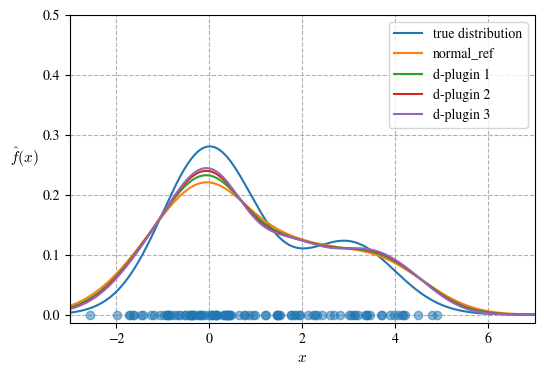

In [10]:
np.random.seed(0)

m_train = 100
a = 0.7
n = 1
x_train1 = np.random.normal(0, 1, size=(int(a * m_train), n))
x_train2 = np.random.normal(3, 1, size=(int((1 - a) * m_train), n))
x_train = np.concatenate((x_train1, x_train2))
x_grid = np.linspace(-3, 7, 1000)[:, None]


plt.figure(figsize=(6, 4), dpi=100)

plt.scatter(x_train, x_train*0, alpha=0.5, zorder=2)

true_dist = a * norm.pdf(x_grid, loc=0, scale=1) + (1 - a) * norm.pdf(x_grid, loc=3, scale=1)
plt.plot(x_grid, true_dist, label="true distribution")

kde = KDE().fit(x_train)
scores = kde.pdf(x_grid)
plt.plot(x_grid, scores, label="normal_ref")
print(f"h dla przybliżonej: {kde.bandwidth}")

for i in range(1, 4):
    kde = KDE().fit(x_train, bandwidth_method="direct_plugin", stage=i)
    scores = kde.pdf(x_grid)
    plt.plot(x_grid, scores, label=f"d-plugin {i}")
    print(f"h dla podstawień (direct) (rząd: {i}):{kde.bandwidth}")

# kde = KDE().fit(x_train, bandwidth_method="ste_plugin")
# scores = kde.pdf(x_grid)
# plt.plot(x_grid, scores, label="ste-plugin")
# print(f"h dla podstawień (solve-the-equation): {kde.bandwidth}")

# kde = KDE().fit(x_train, bandwidth_method="ml_cv")
# scores = kde.pdf(x_grid)
# plt.plot(x_grid, scores, label="ml-cv")
# print(f"h dla największej wiarygodności: {kde.bandwidth}")

plt.legend(fontsize=10)
plt.xlim(-3, 7)
plt.ylim(top=0.5)
plt.xlabel("$x$", fontsize=11)
plt.ylabel("$\hat{f}(x)$", rotation=0, labelpad=13, fontsize=11)
plt.grid(linestyle="--")
# plt.savefig("../docs/images/bandwidth_selection.png", dpi=200)
plt.show()

\newpage

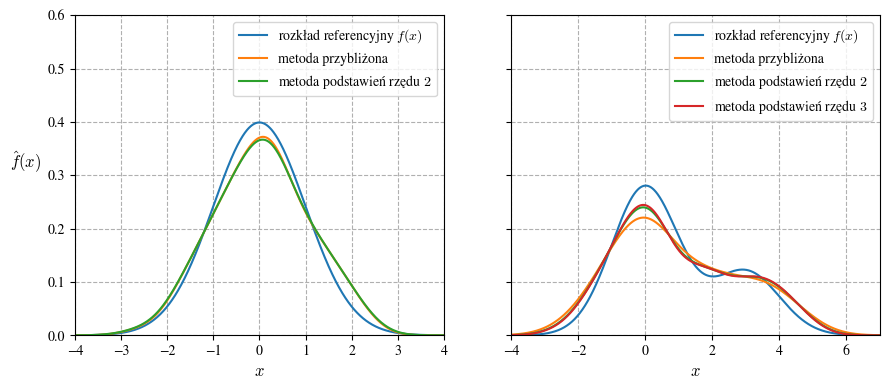

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharey=True, dpi=100)


# plot 1
np.random.seed(0)

m_train = 100
n = 1
x_train = np.random.normal(0, 1, size=(m_train, n))
x_grid = np.linspace(-4, 4, 1000)[:, None]

true_dist = norm.pdf(x_grid)
axs[0].plot(x_grid, true_dist, label="rozkład referencyjny $f(x)$")

kde = KDE().fit(x_train, bandwidth_method="normal_reference")
scores = kde.pdf(x_grid)
axs[0].plot(x_grid, scores, label="metoda przybliżona")

kde = KDE().fit(x_train, bandwidth_method="direct_plugin", stage=2)
scores = kde.pdf(x_grid)
axs[0].plot(x_grid, scores, label="metoda podstawień rzędu $2$")

axs[0].legend()
axs[0].set_xlabel("$x$", fontsize=12)
axs[0].set_ylabel("$\hat{f}(x)$", rotation=0, labelpad=16, fontsize=12)
axs[0].set_xlim(-4, 4)
axs[0].set_ylim(0, 0.6)
axs[0].grid(linestyle="--")


# plot 2
np.random.seed(0)

m_train = 100
a = 0.7
n = 1
x_train1 = np.random.normal(0, 1, size=(int(a * m_train), n))
x_train2 = np.random.normal(3, 1, size=(int((1 - a) * m_train), n))
x_train = np.concatenate((x_train1, x_train2))
x_grid = np.linspace(-4, 7, 1000)[:, None]

true_dist = a * norm.pdf(x_grid, loc=0, scale=1) + (1 - a) * norm.pdf(x_grid, loc=3, scale=1)
axs[1].plot(x_grid, true_dist, label="rozkład referencyjny $f(x)$")

kde = KDE().fit(x_train, bandwidth_method="normal_reference")
scores = kde.pdf(x_grid)
axs[1].plot(x_grid, scores, label="metoda przybliżona")

for i in range(2, 4):
    kde = KDE().fit(x_train, bandwidth_method="direct_plugin", stage=i)
    scores = kde.pdf(x_grid)
    axs[1].plot(x_grid, scores, label=f"metoda podstawień rzędu ${i}$")

axs[1].legend()
axs[1].set_xlabel("$x$", fontsize=12)
axs[1].set_xlim(-4, 7)
axs[1].grid(linestyle="--")

plt.tight_layout(w_pad=4)
# plt.savefig("bandwidth_selection.pdf", format="pdf", bbox_inches="tight")
plt.show()

\newpage

### Przykład 3

Przykład (2d) estymatora jądrowego dla danych wygenerowanych z mieszaniny dwóch rozkładów Gaussa $N([0,0], [[1,0],[0,1]])$ oraz $N([3,0], [[1,0],[0,1]])$ przy udziale 70% pierwszego i 30% drugiego oraz: \
$seed=0$, $n=2$, $m=100$, $w_i=\frac{1}{m}$, jądro normalne

h dla przybliżonej: [0.76009929 0.49085884]
h dla podstawień (direct) (rząd: 2):[0.72797181 0.54387202]
h dla podstawień (direct) (rząd: 3):[0.69810959 0.54599636]


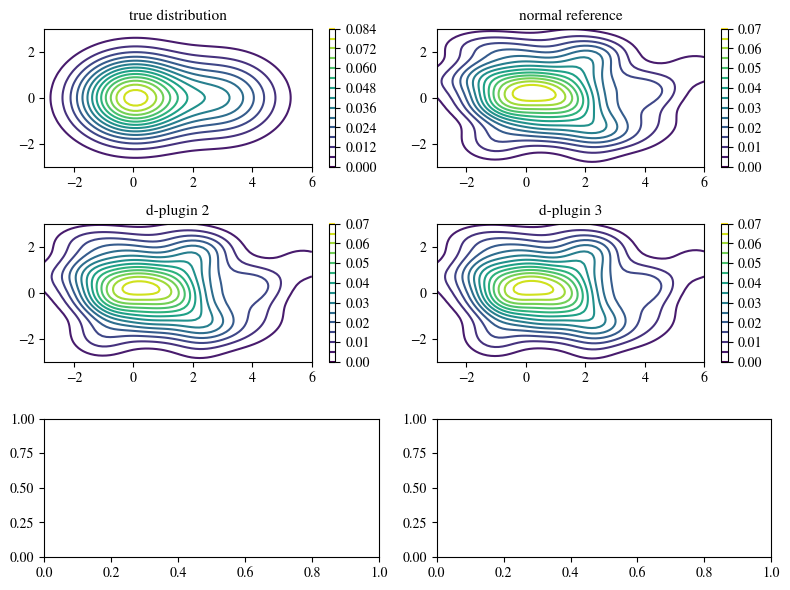

In [12]:
np.random.seed(0)

m_train = 100
mean1 = [0, 0]
mean2 = [3, 0]
cov = [[1.5, 0], [0, 1.3]]
a = 0.7
x_train1 = np.random.multivariate_normal(mean1, cov, size=int(a * m_train))
x_train2 = np.random.multivariate_normal(mean2, cov, size=int((1 - a) * m_train))

x_train = np.concatenate((x_train1, x_train2))

# grid data
x1_min, x1_max = -3, 6
x2_min, x2_max = -3, 3
grid_size = 70

x1 = np.linspace(x1_min, x1_max, grid_size)
x2 = np.linspace(x2_min, x2_max, grid_size)
x1v, x2v = np.meshgrid(x1, x2)
x1p = x1v.reshape(-1, 1)
x2p = x2v.reshape(-1, 1)
x_grid = np.hstack((x1p, x2p))

#
fig, axs = plt.subplots(3, 2, figsize=(8, 6), dpi=100)

true_dist = a * multivariate_normal.pdf(x_grid, mean1, cov) + (1 - a) * multivariate_normal.pdf(x_grid, mean2, cov)
axs[0, 0].set_title("true distribution", fontsize=11)
cp = axs[0, 0].contour(x1v, x2v, true_dist.reshape(grid_size, grid_size), 15)
plt.colorbar(cp, ax=axs[0, 0])

kde = KDE().fit(x_train, bandwidth_method="normal_reference")
scores = kde.pdf(x_grid)
print(f"h dla przybliżonej: {kde.bandwidth}")
axs[0, 1].set_title("normal reference", fontsize=11)
cp = axs[0, 1].contour(x1v, x2v, scores.reshape(grid_size, grid_size), 15)
plt.colorbar(cp, ax=axs[0, 1])

kde = KDE().fit(x_train, bandwidth_method="direct_plugin", stage=2)
scores = kde.pdf(x_grid)
print(f"h dla podstawień (direct) (rząd: 2):{kde.bandwidth}")
axs[1, 0].set_title("d-plugin 2", fontsize=11)
cp = axs[1, 0].contour(x1v, x2v, scores.reshape(grid_size, grid_size), 15)
plt.colorbar(cp, ax=axs[1, 0])

kde = KDE().fit(x_train, bandwidth_method="direct_plugin", stage=3)
scores = kde.pdf(x_grid)
print(f"h dla podstawień (direct) (rząd: 3):{kde.bandwidth}")
axs[1, 1].set_title("d-plugin 3", fontsize=11)
cp = axs[1, 1].contour(x1v, x2v, scores.reshape(grid_size, grid_size), 15)
plt.colorbar(cp, ax=axs[1, 1])

# kde = KDE().fit(x_train, bandwidth_method="ste_plugin")
# scores = kde.pdf(x_grid)
# print(f"h dla podstawień (solve-the-equation):{kde.bandwidth}")
# axs[2, 0].set_title("ste-plugin", fontsize=11)
# cp = axs[2, 0].contour(x1v, x2v, scores.reshape(grid_size, grid_size), 15)
# plt.colorbar(cp, ax=axs[2, 0])

# kde = KDE().fit(x_train, bandwidth_method="ml_cv")
# scores = kde.pdf(x_grid)
# print(f"h dla największej wiarygodności: {kde.bandwidth}")
# axs[2, 1].set_title("ml-cv", fontsize=11)
# cp = axs[2, 1].contour(x1v, x2v, scores.reshape(grid_size, grid_size), 15)
# plt.colorbar(cp, ax=axs[2, 1])

plt.tight_layout()
plt.show()

h dla przybliżonej: [0.76009929 0.49085884]
h dla podstawień (direct) (rząd: 2):[0.72797181 0.54387202]
h dla podstawień (direct) (rząd: 3):[0.69810959 0.54599636]


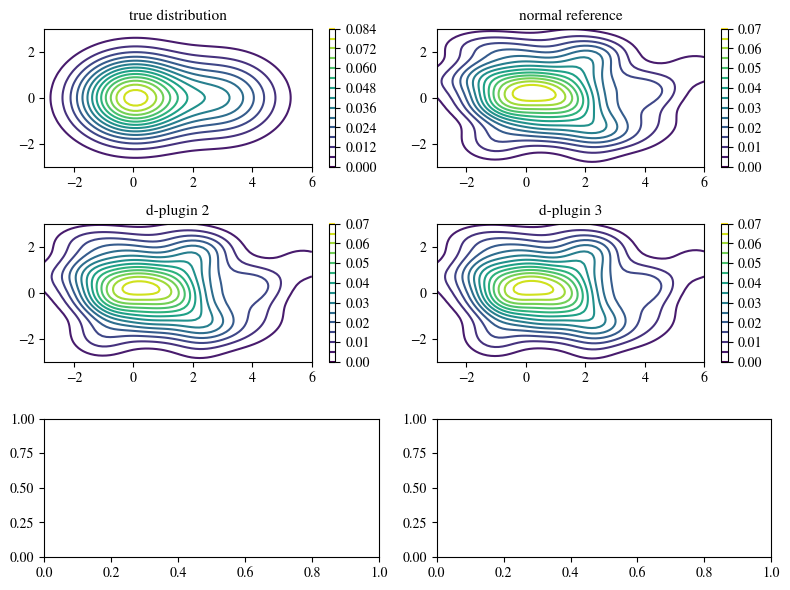

In [13]:
np.random.seed(0)

m_train = 100
mean1 = [0, 0]
mean2 = [3, 0]
cov = [[1.5, 0], [0, 1.3]]
a = 0.7
x_train1 = np.random.multivariate_normal(mean1, cov, size=int(a * m_train))
x_train2 = np.random.multivariate_normal(mean2, cov, size=int((1 - a) * m_train))

x_train = np.concatenate((x_train1, x_train2))

# grid data
x1_min, x1_max = -3, 6
x2_min, x2_max = -3, 3
grid_size = 70

x1 = np.linspace(x1_min, x1_max, grid_size)
x2 = np.linspace(x2_min, x2_max, grid_size)
x1v, x2v = np.meshgrid(x1, x2)
x1p = x1v.reshape(-1, 1)
x2p = x2v.reshape(-1, 1)
x_grid = np.hstack((x1p, x2p))

#
fig, axs = plt.subplots(3, 2, figsize=(8, 6), dpi=100)

true_dist = a * multivariate_normal.pdf(x_grid, mean1, cov) + (1 - a) * multivariate_normal.pdf(x_grid, mean2, cov)
axs[0, 0].set_title("true distribution", fontsize=11)
cp = axs[0, 0].contour(x1v, x2v, true_dist.reshape(grid_size, grid_size), 15)
plt.colorbar(cp, ax=axs[0, 0])

kde = KDE().fit(x_train, bandwidth_method="normal_reference")
scores = kde.pdf(x_grid)
print(f"h dla przybliżonej: {kde.bandwidth}")
axs[0, 1].set_title("normal reference", fontsize=11)
cp = axs[0, 1].contour(x1v, x2v, scores.reshape(grid_size, grid_size), 15)
plt.colorbar(cp, ax=axs[0, 1])

kde = KDE().fit(x_train, bandwidth_method="direct_plugin", stage=2)
scores = kde.pdf(x_grid)
print(f"h dla podstawień (direct) (rząd: 2):{kde.bandwidth}")
axs[1, 0].set_title("d-plugin 2", fontsize=11)
cp = axs[1, 0].contour(x1v, x2v, scores.reshape(grid_size, grid_size), 15)
plt.colorbar(cp, ax=axs[1, 0])

kde = KDE().fit(x_train, bandwidth_method="direct_plugin", stage=3)
scores = kde.pdf(x_grid)
print(f"h dla podstawień (direct) (rząd: 3):{kde.bandwidth}")
axs[1, 1].set_title("d-plugin 3", fontsize=11)
cp = axs[1, 1].contour(x1v, x2v, scores.reshape(grid_size, grid_size), 15)
plt.colorbar(cp, ax=axs[1, 1])

# kde = KDE().fit(x_train, bandwidth_method="ste_plugin")
# scores = kde.pdf(x_grid)
# print(f"h dla podstawień (solve-the-equation):{kde.bandwidth}")
# axs[2, 0].set_title("ste-plugin", fontsize=11)
# cp = axs[2, 0].contour(x1v, x2v, scores.reshape(grid_size, grid_size), 15)
# plt.colorbar(cp, ax=axs[2, 0])

# kde = KDE().fit(x_train, bandwidth_method="ml_cv")
# scores = kde.pdf(x_grid)
# print(f"h dla największej wiarygodności: {kde.bandwidth}")
# axs[2, 1].set_title("ml-cv", fontsize=11)
# cp = axs[2, 1].contour(x1v, x2v, scores.reshape(grid_size, grid_size), 15)
# plt.colorbar(cp, ax=axs[2, 1])

plt.tight_layout()
plt.show()

\newpage

### Komentarz do całej sekcji 1.4

Orientacyjny (przykładowy) czas wyliczenia parametru wygładzania (przy $m=10000$ i $n = 1$) za pomocą metody przybliżonej to 4ms, metody podstawień (direct) rzędu 2 30s, metody podstawień (solve-the-equation) 3min, metody największej wiarygodności 32s.

Komentarz PK:

$\color{blue}{\text{Parametr wygładzania: metoda przybliżona dla unimodalnych, direct plug-in rzędu 2 i 3 dla 2- i więcej-modalnych. }}$

### Źródła

* (Wand, M. P. and Jones, M. C. Kernel Smoothing, 1995, od strony 58)

Normal reference (metoda przybliżona), Least squares cross-validation, Biased cross-validation,  Direct plugin (metoda podstawień), solve-the-equation plug-in (Shealther and Jones rule)

* (Silverman, Density Estimation for Statistics and Data Analysis, 1986, od strony 43)

Likelihood cross-validation na stronach 52-55

* [stack: scotts rule vs silverman rule](https://stats.stackexchange.com/questions/90656/kernel-bandwidth-scotts-vs-silvermans-rules)

Reguła scotta vs reguła silvermana


* [The importance of kernel density estimation bandwidth](https://aakinshin.net/posts/kde-bw/)

Krótki i zwięzły tekst na temat doboru parametru wygładzania wraz z odwołaniami do ciekawych źródeł

* [Heidenreich, Bandwidth selection for kernel density estimation: a review of fully automatic selectors](https://core.ac.uk/download/pdf/159147961.pdf)
* Jones, A brief survey of bandwidth selection for density estimation

Podkreślenie zalet metod plug-in

* [Turlach, Bandwidth Selection in Kernel Density Estimation: A Review](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.44.6770&rep=rep1&type=pdf)

Od strony 26 mamy pomocniczy (implementacyjnie) zapis metod: Least Squares Cross-Validation, Biased Cross-Validation, Smoothed Cross-Validation, Bandwidth Factorized Smoothed Cross-Validation, Park and Marron Plug-In, Sheather and Jones Plug-In

* [A COMPARATIVE REVIEW OF BANDWIDTH SELECTION
FOR KERNEL DENSITY ESTIMATION](http://www3.stat.sinica.edu.tw/statistica/oldpdf/A6n18.pdf)
* [Botev, KERNEL DENSITY ESTIMATION VIA DIFFUSION](https://arxiv.org/pdf/1011.2602.pdf)

Improved Sheather-Jones (ISJ) algorithm

\newpage

## Biblioteki w Pythonie z zaimplementowanym KDE

|  | sklearn | scipy |
| --------- | ------ | ------ |
| Algorithm | kd_tree, ball_tree | Naive with radial kernel |
| #Dims | Any | Any |
| Weighted data | Yes | Yes |
| Automatic bandwidth | None | 'scott', 'silverman'|
| #Kernels | 6 | 1 (gaussian) |
| Comment | Partly in (?) Cython (but slow) | Cython |

|   | statsmodels (uni) | statsmodels (multi) |
| ----------- | ----------------- | ------------------- |
| Algorithm | Naive (product); fft for gauss | Naive (product) |
| #Dims | 1 | Any |
| Weighted data | Yes | No |
| Automatic bandwidth | 'scott', 'silverman' | 'cv_ml', 'cv_ls' |
| #Kernels | 7 (1 for FFT) | 1 (gaussian) |
| Comment | Vectorized (memory inefficient) | Vectorized (memory inefficient) |

**W bibliotece statsmodels jest implementacja estymatora warunkowego KDEMultivariateConditional**

## Komentarz do sekcji 1

$\color{red}{\text{Czas wyliczenia estymatora jądrego zbudowanego na próbie o liczności } m=10^4, n=1}$
$\color{red}{\text{na 50 testowych punktach używając metody podstawień drugiego rzędu trwa 30s.}}$

$\color{red}{\text{Tyle samo czasu zajmują takie wyliczenia metodą przybliżoną, ale przy } m=3*10^7.}$

\newpage

# Klasyfikator

Klasyfikator bayes'owski:
$$
P(C=c|X=x) \propto \pi_c \hat{f}_c(X=x)
$$

$$
\underset{c}{\mathrm{argmax}} \;  P(C=c|X=x)
$$

* $\hat{f}_c$ - Estymator jądrowy dla zbioru z klasy $c$
* $\pi_c$ - Prawdopodobieństwo a priori klasy $c$ (w szczególności jest to frakcja elementów klasy $c$ w całym zbiorze)

Komentarz:

Parametr wygładzania wyliczany jest osobno w każdym estymatorze $\hat{f}_c$ (takie jest domyślne zachowanie programu). Alternatywnie można wyliczyć jeden parametr wygładzania na pełnym zbiorze i wykorzystać go w każdym estymatorze $\hat{f}_c$ - istnieje taka opcja w zaimplementowanej procedurze.  

## Źródła

* (Silverman, B. W. Density Estimation for Statistics and Data Analysis) - sekcja 6.1

* (Scott, Multivariate density estimation) - sekcja 9.1

* [Sklearn Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)

* H. Zhang (2004). The optimality of Naive Bayes. Proc. FLAIRS

* The Elements of Statistical Learning”, Hastie T., Tibshirani R., Friedman J., Section 4.3, p.106-119, 2008.

## Wskaźnik jakości

Dokładność (accuracy), czyli procent dobrze sklasyfikowanych elementów metodą leave-one-out

Tworzymy $m$ modeli na zbiorze bez $i$-tego elementu i testujemy klasyfikator na $i$-tym elemencie. Ostatecznie mamy wyliczoną dokładność dla całego $m$-elementowego zbioru.

Notka: Naszym celem jest maksymalizacja wskaźnika

\newpage

## Przykład 1

Przykład jednowymiarowy na danych pochodzących z dwóch rozkładów normalnych $N(0, 1)$ oraz $N(3, 1)$ przy udziale 25% pierwszego i 75% drugiego : \
$seed=0$, $n=1$, $m=100$, $w_i=\frac{1}{m}$, jądro normalne, metoda przybliżona

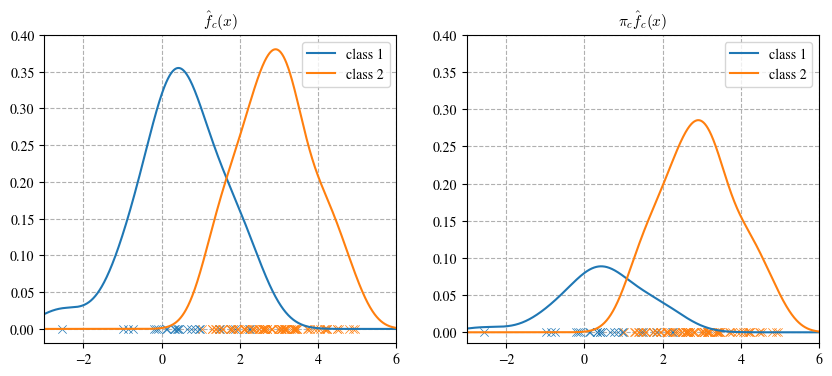

In [18]:
np.random.seed(0)


# Data
m_train = 100
n = 1
m_train1 = m_train // 4
x_train1 = np.random.normal(0, 1, size=(m_train1, n))
labels_train1 = np.full(m_train1, 1)
m_train2 = m_train - m_train1 
x_train2 = np.random.normal(3, 1, size=(m_train2, n))
labels_train2 = np.full(m_train2, 2)
x_train = np.concatenate((x_train1, x_train2))
labels_train = np.concatenate((labels_train1, labels_train2))

x_grid = np.linspace(-3, 6, 1000)[:, None]
kde1 = KDE().fit(x_train1)
scores1 = kde1.pdf(x_grid)
kde2 = KDE().fit(x_train2)
scores2 = kde2.pdf(x_grid)


# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

axs[0].scatter(x_train1, x_train1*0, marker="x", zorder=2, linewidths=0.5)
axs[0].scatter(x_train2, x_train2*0, marker="x", zorder=2, linewidths=0.5)
axs[0].plot(x_grid, scores1, label="class 1")
axs[0].plot(x_grid, scores2, label="class 2")
axs[0].set_title("$\hat{f}_c(x)$", fontsize=11)
axs[0].legend(fontsize=10)
axs[0].set_xlim(-3, 6)
axs[0].set_ylim(top=0.4)
axs[0].grid(linestyle="--")

axs[1].scatter(x_train1, x_train1*0, marker="x", zorder=2, linewidths=0.5)
axs[1].scatter(x_train2, x_train2*0, marker="x", zorder=2, linewidths=0.5)
axs[1].plot(x_grid, m_train1 / m_train * scores1, label="class 1")
axs[1].plot(x_grid, m_train2 / m_train * scores2, label="class 2")
axs[1].set_title("$\\pi_c \\hat{f}_c(x)$", fontsize=11)
axs[1].legend(fontsize=10)
axs[1].set_xlim(-3, 6)
axs[1].set_ylim(top=0.4)
axs[1].grid(linestyle="--")

plt.show()

In [19]:
model = KDEClassification()
accuracy = accuracy_loo(x_train, labels_train, model)
print(f"Dokładność leave-one-out: {100 * accuracy:.3f}%")

Dokładność leave-one-out: 93.000%


\newpage

### Wyniki w postaci rozmytej

Funkcja przynależności $x$ do klasy $c$:

$$\mu_c^*(x) = \frac{\pi_c \hat{f}_c(x)}{\sum_{k=1}^{n_C} \pi_k \hat{f}_k(x)}$$

* $n_C$ - liczba klas
* $\pi_c$ - Prawdopodobieństwo a priori klasy $c$ (w szczególności jest to frakcja elementów klasy $c$ w całym zbiorze)

Spostrzeżenie: $\sum_{k=1}^{n_C} \mu_k^*(x) = 1$

Wyniki w postaci rozmytej do powyższego przykładu

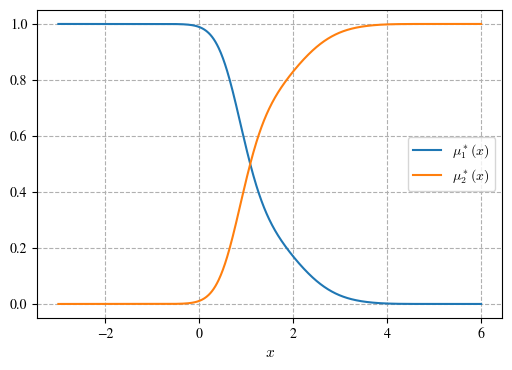

In [20]:
classifier = KDEClassification().fit(x_train, labels_train)
scores = classifier.pdfs(x_grid)
scores *= classifier.prior

u_fuzzy = np.zeros(scores.shape)
mask = np.any(scores != 0, axis=1)
u_fuzzy[mask] = scores[mask] / scores[mask].sum(axis=1)[:, None]

# Plot
plt.figure(figsize=(6, 4), dpi=100)

plt.plot(x_grid, u_fuzzy)

plt.xlabel("$x$", fontsize=11)
plt.legend([f"$\mu^*_{label}(x)$" for label in np.unique(labels_train)], fontsize=10)
plt.grid(linestyle="--")
plt.show()

\newpage

### Wyniki w postaci intuicjonistycznej

Funkcje przynależności uzupełnione o margines wahania:

$$\mu_c(x) = (1-\pi(x))\mu_c^*(x)$$

$$\pi(x) = \sqrt{ a \frac{\hat{g}_{-}(x)}{\underset{x_{-}}{\mathrm{max}} \; \hat{g}_{-}(x_{-})} }$$

$$a = \frac{\hat{g}_{-}(x_*)}{\hat{g}_{-}(x_*) + \hat{g}_{+}(x_*)}$$

* $\hat{g}_{-}(x)$ - estymator zbudowany na błędnie sklasyfikowanych elementach
* $\hat{g}_{+}(x)$ - estymator zbudowany na poprawnie sklasyfikowanych elementach
* $x_*$ - element, dla którego osiągnieto maksimum w $\underset{x_{-}}{\mathrm{max}} \; \hat{g}_{-}(x_{-})$
* $x_{-}$ - elementy źle sklasyfikowane

Spostrzeżenie: $\pi(x) + \sum_{k=1}^{n_c} \mu_k(x) = 1$. Jeśli wszystkie elementy są źle sklasyfikowane to $\pi(x)=1$, natomiast, gdy wszystkie są dobrze sklasyfikowane to $\pi(x)=0$.

Wyniki w postaci intuicjonistycznej do powyższego przykładu

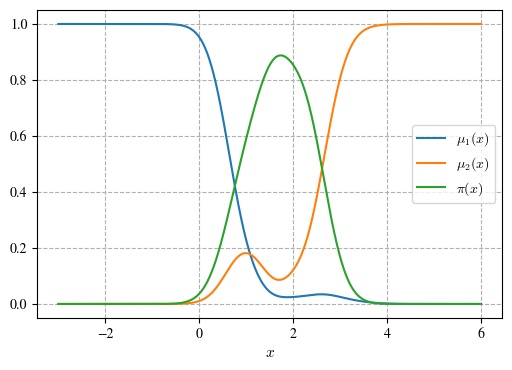

In [21]:
classifier = KDEClassification().fit(x_train, labels_train)
labels_pred_tmp = classifier.predict(x_train)
mask_pred = labels_pred_tmp == labels_train
correctly_classified = np.sum(mask_pred)

if correctly_classified == 0:
    pi = np.full(x_grid.shape[0], 1)
elif correctly_classified == m_train:
    pi = np.full(x_grid.shape[0], 0)
else:
    x_train_good = x_train[mask_pred]
    x_train_bad = x_train[~mask_pred]

    kde_good = KDE().fit(x_train_good)
    kde_bad = KDE().fit(x_train_bad)

    scores_on_x_train_bad = kde_bad.pdf(x_train_bad)
    argmax_scores_on_x_train_bad = scores_on_x_train_bad.argmax()
    tmp_bad = kde_bad.pdf(x_train_bad[argmax_scores_on_x_train_bad][:, None])
    tmp_good = kde_good.pdf(x_train_bad[argmax_scores_on_x_train_bad][:, None])
    c = tmp_bad / (tmp_bad + tmp_good)

    scores_on_x = kde_bad.pdf(x_grid)
    pi = c * scores_on_x / scores_on_x_train_bad[argmax_scores_on_x_train_bad]

pi = np.sqrt(pi)
u_intuitionistic = (1 - pi[:, None]) * u_fuzzy

# Plot
plt.figure(figsize=(6, 4), dpi=100)

plt.plot(x_grid, u_intuitionistic)
plt.plot(x_grid, pi)

plt.xlabel("$x$", fontsize=11)
legend = [f"$\mu_{label}(x)$" for label in np.unique(labels_train)]
legend.append("$\pi(x)$")
plt.legend(legend, fontsize=10)
plt.grid(linestyle="--")
plt.show()

\newpage

## Przykład 2

Przykład (2d) dla dwóch rozkładów (klas) Gaussa $N([0,0], [[1,0.85],[0.85,1]])$ oraz $N([0,0], [[1,-0.85],[-0.85,1]])$ przy udziale 50% pierwszego i 50% drugiego oraz: \
$seed=0$, $n=2$, $m=100$, $w_i=\frac{1}{m}$, jądro normalne, metoda przybliżona

Dla porównania dodałem wyniki czterech innych algorytmów (w tym trzech bayesowskich):

* Naive Bayes - wykorzystanie rozkładu normalnego (w $\hat{f}_c(X=x)$) przy założeniu niezależności zmiennych
* Linear Discriminant Analysis - wykorzystanie rozkładu normalnego (w $\hat{f}_c(X=x)$) przy założeniu, że rozkład każdej klasy ma/dzieli tę samą macierz kowariancji
* Quadratic Discriminant Analysis - wykorzystanie rozkładu normalnego (w $\hat{f}_c(X=x)$) przy założeniu, że rozkład każdej klasy ma własną macierz kowariancji

* K nearest neighbors - przy $k = \sqrt{m}$

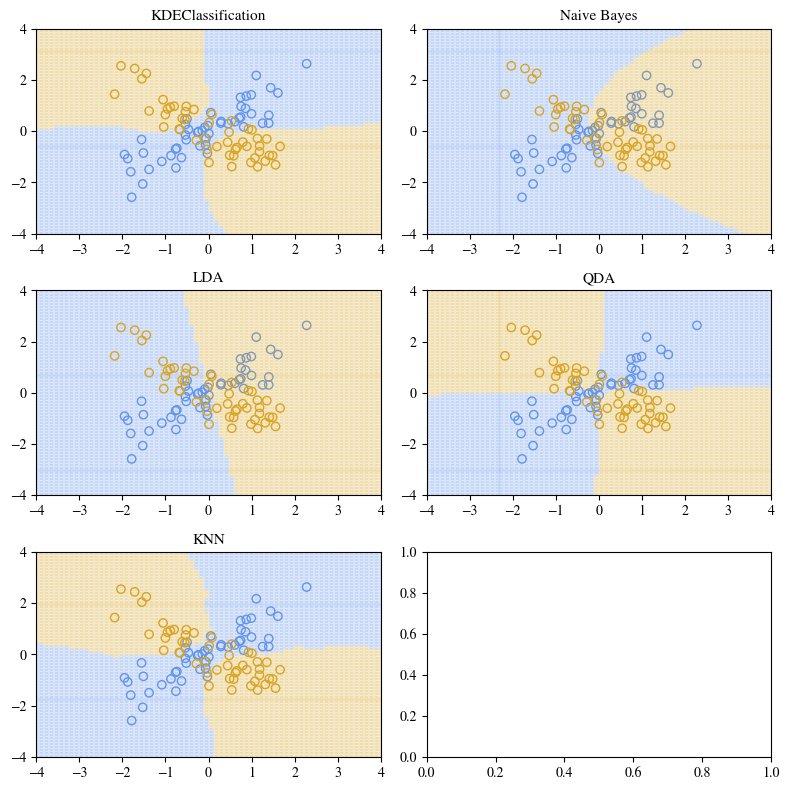

In [22]:
np.random.seed(0)


# Data
m_train = 100

## class 1
cov1 = [[1, 0.85], [0.85, 1]]
x_train1 = np.random.multivariate_normal([0, 0], cov1, m_train // 2)
labels_train1 = np.full(m_train // 2, 1)
## class 2
cov2 = [[1, -0.85], [-0.85, 1]]
x_train2 = np.random.multivariate_normal([0, 0], cov2, m_train // 2)
labels_train2 = np.full(m_train // 2, 2)

x_train = np.concatenate((x_train1, x_train2))  # shape (1000, 2)
labels_train = np.concatenate((labels_train1, labels_train2))  # shape (1000,)


# Prepare 2d grid for plotting decision boundary
grid_size = 70
x1 = np.linspace(-4, 4, grid_size)
x2 = np.linspace(-4, 4, grid_size)
x1v, x2v = np.meshgrid(x1, x2)
x1p = x1v.reshape(-1, 1)
x2p = x2v.reshape(-1, 1)
x_grid = np.hstack((x1p, x2p))  # shape (4900, 2)


# Plot
fig, axs = plt.subplots(3, 2, figsize=(8, 8), dpi=100)

model1 = KDEClassification().fit(x_train, labels_train)
labels_pred = model1.predict(x_grid)
axs[0, 0].set_title("KDEClassification", fontsize=11)
for label, color in zip(np.unique(labels_train), ["cornflowerblue", "goldenrod"]):
    mask1 = (labels_train == label)
    axs[0, 0].scatter(x_train[mask1, 0], x_train[mask1, 1], facecolors="none",
                edgecolors=color, label=f"class {label}")
    mask2 = (labels_pred == label)
    axs[0, 0].scatter(x1p[mask2, 0], x2p[mask2, 0],
                color=color, marker=".", alpha=0.15)
axs[0, 0].set_xlim(-4, 4)
axs[0, 0].set_ylim(-4, 4)

model2 = GaussianNB().fit(x_train, labels_train)
labels_pred = model2.predict(x_grid)
axs[0, 1].set_title("Naive Bayes", fontsize=11)
for label, color in zip(np.unique(labels_train), ["cornflowerblue", "goldenrod"]):
    mask1 = (labels_train == label)
    axs[0, 1].scatter(x_train[mask1, 0], x_train[mask1, 1], facecolors="none",
                edgecolors=color, label=f"class {label}")
    mask2 = (labels_pred == label)
    axs[0, 1].scatter(x1p[mask2, 0], x2p[mask2, 0],
                color=color, marker=".", alpha=0.15)
axs[0, 1].set_xlim(-4, 4)
axs[0, 1].set_ylim(-4, 4)

model3 = LinearDiscriminantAnalysis().fit(x_train, labels_train)
labels_pred = model3.predict(x_grid)
axs[1, 0].set_title("LDA", fontsize=11)
for label, color in zip(np.unique(labels_train), ["cornflowerblue", "goldenrod"]):
    mask1 = (labels_train == label)
    axs[1, 0].scatter(x_train[mask1, 0], x_train[mask1, 1], facecolors="none",
                edgecolors=color, label=f"class {label}")
    mask2 = (labels_pred == label)
    axs[1, 0].scatter(x1p[mask2, 0], x2p[mask2, 0],
                color=color, marker=".", alpha=0.15)
axs[1, 0].set_xlim(-4, 4)
axs[1, 0].set_ylim(-4, 4)

model4 = QuadraticDiscriminantAnalysis().fit(x_train, labels_train)
labels_pred = model4.predict(x_grid)
axs[1, 1].set_title("QDA", fontsize=11)
for label, color in zip(np.unique(labels_train), ["cornflowerblue", "goldenrod"]):
    mask1 = (labels_train == label)
    axs[1, 1].scatter(x_train[mask1, 0], x_train[mask1, 1], facecolors="none",
                edgecolors=color, label=f"class {label}")
    mask2 = (labels_pred == label)
    axs[1, 1].scatter(x1p[mask2, 0], x2p[mask2, 0],
                color=color, marker=".", alpha=0.15)
axs[1, 1].set_xlim(-4, 4)
axs[1, 1].set_ylim(-4, 4)

k = int(np.sqrt(m_train))
model5 = KNeighborsClassifier(n_neighbors=k, algorithm="brute").fit(x_train, labels_train)
labels_pred = model5.predict(x_grid)
axs[2, 0].set_title("KNN", fontsize=11)
for label, color in zip(np.unique(labels_train), ["cornflowerblue", "goldenrod"]):
    mask1 = (labels_train == label)
    axs[2, 0].scatter(x_train[mask1, 0], x_train[mask1, 1], facecolors="none",
                edgecolors=color, label=f"class {label}")
    mask2 = (labels_pred == label)
    axs[2, 0].scatter(x1p[mask2, 0], x2p[mask2, 0],
                color=color, marker=".", alpha=0.15)
axs[2, 0].set_xlim(-4, 4)
axs[2, 0].set_ylim(-4, 4)

plt.tight_layout()
plt.show()

In [23]:
model = KDEClassification()
accuracy = accuracy_loo(x_train, labels_train, model)
print(f"[KDEClassifier] Dokładność leave-one-out: {100 * accuracy:.3f}%")

model = GaussianNB()
accuracy = accuracy_loo(x_train, labels_train, model)
print(f"[Naive Bayes] Dokładność leave-one-out: {100 * accuracy:.3f}%")

model = LinearDiscriminantAnalysis()
accuracy = accuracy_loo(x_train, labels_train, model)
print(f"[LDA] Dokładność leave-one-out: {100 * accuracy:.3f}%")

model = LinearDiscriminantAnalysis()
accuracy = accuracy_loo(x_train, labels_train, model)
print(f"[LDA] Dokładność leave-one-out: {100 * accuracy:.3f}%")

model = QuadraticDiscriminantAnalysis()
accuracy = accuracy_loo(x_train, labels_train, model)
print(f"[QDA] Dokładność leave-one-out: {100 * accuracy:.3f}%")

model = KNeighborsClassifier(n_neighbors=k, algorithm="brute")
accuracy = accuracy_loo(x_train, labels_train, model)
print(f"[KNN] Dokładność leave-one-out: {100 * accuracy:.3f}%")

[KDEClassifier] Dokładność leave-one-out: 87.000%
[Naive Bayes] Dokładność leave-one-out: 34.000%
[LDA] Dokładność leave-one-out: 43.000%
[LDA] Dokładność leave-one-out: 43.000%
[QDA] Dokładność leave-one-out: 87.000%
[KNN] Dokładność leave-one-out: 86.000%


\newpage

## Przykład 3

Przykład (2d) dla danych "księżycowych" przy: \
$seed=0$, $n=2$, $m=100$, $w_i=\frac{1}{m}$, jądro normalne, metoda przybliżona

Dla porównania dodałem wyniki czterech innych algorytmów: Naive Bayes, Linear Discriminant Analysis, Quadratic Discriminant Analysis, K nearest neighbors

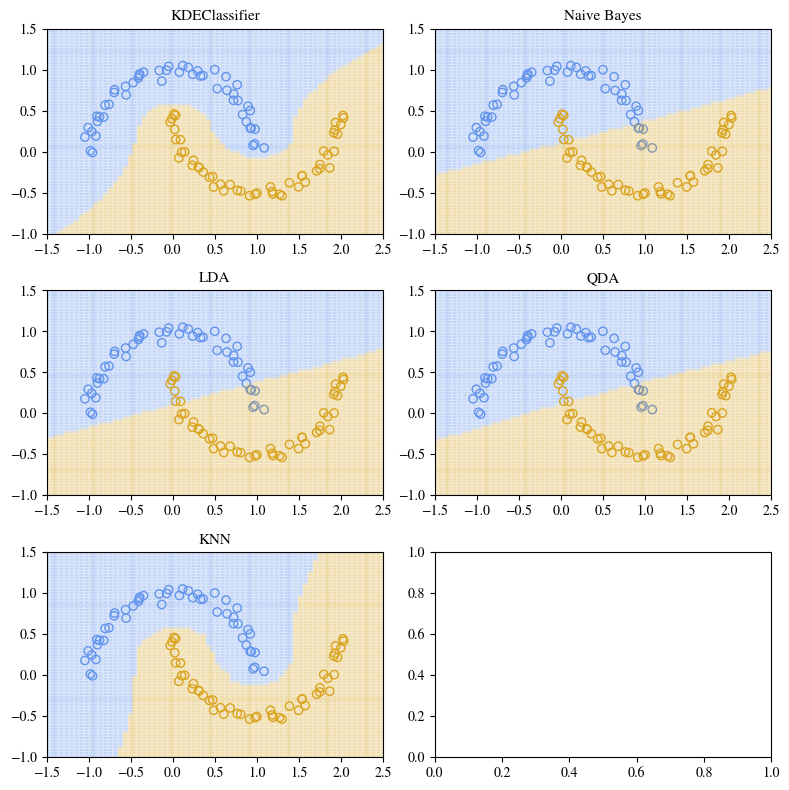

In [24]:
np.random.seed(0)

# Data
m_train = 100
x_train, labels_train = make_moons(n_samples=m_train, noise=0.05)


# Prepare 2d grid for plotting decision boundary
grid_size = 70
x1 = np.linspace(-1.5, 2.5, grid_size)
x2 = np.linspace(-1, 1.5, grid_size)
x1v, x2v = np.meshgrid(x1, x2)
x1p = x1v.reshape(-1, 1)
x2p = x2v.reshape(-1, 1)
x_grid = np.hstack((x1p, x2p))  # shape (4900, 2)


fig, axs = plt.subplots(3, 2, figsize=(8, 8), dpi=100)

model1 = KDEClassification().fit(x_train, labels_train)
labels_pred = model1.predict(x_grid)
axs[0, 0].set_title("KDEClassifier", fontsize=11)
for label, color in zip(np.unique(labels_train), ["cornflowerblue", "goldenrod"]):
    mask1 = (labels_train == label)
    axs[0, 0].scatter(x_train[mask1, 0], x_train[mask1, 1], facecolors="none",
                edgecolors=color, label=f"class {label}")
    mask2 = (labels_pred == label)
    axs[0, 0].scatter(x1p[mask2, 0], x2p[mask2, 0],
                color=color, marker=".", alpha=0.15)
axs[0, 0].set_xlim(-1.5, 2.5)
axs[0, 0].set_ylim(-1, 1.5)

model2 = GaussianNB().fit(x_train, labels_train)
labels_pred = model2.predict(x_grid)
axs[0, 1].set_title("Naive Bayes", fontsize=11)
for label, color in zip(np.unique(labels_train), ["cornflowerblue", "goldenrod"]):
    mask1 = (labels_train == label)
    axs[0, 1].scatter(x_train[mask1, 0], x_train[mask1, 1], facecolors="none",
                edgecolors=color, label=f"class {label}")
    mask2 = (labels_pred == label)
    axs[0, 1].scatter(x1p[mask2, 0], x2p[mask2, 0],
                color=color, marker=".", alpha=0.15)
axs[0, 1].set_xlim(-1.5, 2.5)
axs[0, 1].set_ylim(-1, 1.5)

model3 = LinearDiscriminantAnalysis().fit(x_train, labels_train)
labels_pred = model3.predict(x_grid)
axs[1, 0].set_title("LDA", fontsize=11)
for label, color in zip(np.unique(labels_train), ["cornflowerblue", "goldenrod"]):
    mask1 = (labels_train == label)
    axs[1, 0].scatter(x_train[mask1, 0], x_train[mask1, 1], facecolors="none",
                edgecolors=color, label=f"class {label}")
    mask2 = (labels_pred == label)
    axs[1, 0].scatter(x1p[mask2, 0], x2p[mask2, 0],
                color=color, marker=".", alpha=0.15)
axs[1, 0].set_xlim(-1.5, 2.5)
axs[1, 0].set_ylim(-1, 1.5)

model4 = QuadraticDiscriminantAnalysis().fit(x_train, labels_train)
labels_pred = model4.predict(x_grid)
axs[1, 1].set_title("QDA", fontsize=11)
for label, color in zip(np.unique(labels_train), ["cornflowerblue", "goldenrod"]):
    mask1 = (labels_train == label)
    axs[1, 1].scatter(x_train[mask1, 0], x_train[mask1, 1], facecolors="none",
                edgecolors=color, label=f"class {label}")
    mask2 = (labels_pred == label)
    axs[1, 1].scatter(x1p[mask2, 0], x2p[mask2, 0],
                color=color, marker=".", alpha=0.15)
axs[1, 1].set_xlim(-1.5, 2.5)
axs[1, 1].set_ylim(-1, 1.5)

k = int(np.sqrt(m_train))
model5 = KNeighborsClassifier(n_neighbors=k, algorithm="brute").fit(x_train, labels_train)
labels_pred = model5.predict(x_grid)
axs[2, 0].set_title("KNN", fontsize=11)
for label, color in zip(np.unique(labels_train), ["cornflowerblue", "goldenrod"]):
    mask1 = (labels_train == label)
    axs[2, 0].scatter(x_train[mask1, 0], x_train[mask1, 1], facecolors="none",
                edgecolors=color, label=f"class {label}")
    mask2 = (labels_pred == label)
    axs[2, 0].scatter(x1p[mask2, 0], x2p[mask2, 0],
                color=color, marker=".", alpha=0.15)
axs[2, 0].set_xlim(-1.5, 2.5)
axs[2, 0].set_ylim(-1, 1.5)

plt.tight_layout()
plt.show()

In [25]:
model = KDEClassification()
accuracy = accuracy_loo(x_train, labels_train, model)
print(f"[KDEClassifier] Dokładność leave-one-out: {100 * accuracy:.3f}%")

model = GaussianNB()
accuracy = accuracy_loo(x_train, labels_train, model)
print(f"[Naive Bayes] Dokładność leave-one-out: {100 * accuracy:.3f}%")

model = LinearDiscriminantAnalysis()
accuracy = accuracy_loo(x_train, labels_train, model)
print(f"[LDA] Dokładność leave-one-out: {100 * accuracy:.3f}%")

model = LinearDiscriminantAnalysis()
accuracy = accuracy_loo(x_train, labels_train, model)
print(f"[LDA] Dokładność leave-one-out: {100 * accuracy:.3f}%")

model = QuadraticDiscriminantAnalysis()
accuracy = accuracy_loo(x_train, labels_train, model)
print(f"[QDA] Dokładność leave-one-out: {100 * accuracy:.3f}%")

model = KNeighborsClassifier(n_neighbors=k, algorithm="brute")
accuracy = accuracy_loo(x_train, labels_train, model)
print(f"[KNN] Dokładność leave-one-out: {100 * accuracy:.3f}%")

[KDEClassifier] Dokładność leave-one-out: 100.000%
[Naive Bayes] Dokładność leave-one-out: 87.000%
[LDA] Dokładność leave-one-out: 87.000%
[LDA] Dokładność leave-one-out: 87.000%
[QDA] Dokładność leave-one-out: 86.000%
[KNN] Dokładność leave-one-out: 100.000%


\newpage

# Wykrywanie elementów odstających

Mamy $m$-elementowy zbiór danych $x_i$, gdzie $x_i \in \mathbb{R}^n$ i chcemy wyznaczyć elementy odstające w następujący sposób:

* Wyliczamy zbiór wartości estymatora gęstości dla każdego elementu: $\hat{f}_X(x_1),...,\hat{f}_X(x_m)$
* Dla takiego zbioru wyliczamy kwantyl rzędu $r$ oznaczony jako $q_r$. Wartość $q_r$ stanowi próg oddzielający wartości nietypowe od typowych
* Elementy nietypowe to wszystkie te, dla których $\hat{f}_X(x_i) \leq q_r$, natomiast elementy typowe to te spełniające nierówność $\hat{f}_X(x_i) > q_r$

Pozostaje parametr $r$ do wyznaczenia. Proponowaną domyślną wartością tego parametru jest $0.1$.

## Źródła

* (Rob J. Hyndman, Sample Quantiles in Statistical Packages) - sposoby wyliczania kwantyla

## Wskaźnik jakości

Mamy zbiór elementów typowych $x_1^{in}, x_2^{in},...,x_{m_{in}}^{in}$ oraz zbiór elementów nietypowych $x_1^{out}, x_2^{out},...,x_{m_{out}}^{out}$, podczas gdy $m_{out} < m_{in}$.

Dla obu tych zbiorów wyliczamy $\hat{f}(x_1^{in}), \hat{f}(x_2^{in}),..., \hat{f}(x_{m_{in}}^{in})$ oraz $\hat{f}(x_1^{out}), \hat{f}(x_2^{out}),..., \hat{f}(x_{m_{out}}^{out})$.

Zbiór $\hat{f}(x_1^{in}), \hat{f}(x_2^{in}),..., \hat{f}(x_{m_{in}}^{in})$ porządkujemy niemalejąco i bierzemy pierwsze $m_{out}$ wartości z tak uporządkowanego zbioru.

Wskaźnik jakośći:

$$PI_{KF} = \frac{\sum_{i=1}^{m_{out}} \hat{f}(x_i^{out})}{\sum_{i=1}^{m_{out}} \hat{f}(x_i^{in})}$$

Obserwacja: w liczniku biorą udział wszystkie elementy nietypowe, natomiast w mianowniku tylko $m_{out}$ elementów typowych o najmniejszych wartościach estymatora gęstości.

Notka: Naszym celem jest minimalizacja wskaźnika

\newpage

## Przykład 1

Przykład jednowymiarowy na danych pochodzących z rozkładu normalnego $N(0, 1)$: \
$seed=0$, $n=1$, $m=100$, $w_i=\frac{1}{m}$, $r=0.1$, jądro normalne, metoda przybliżona

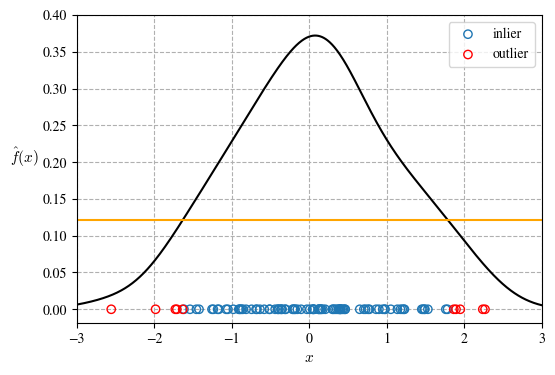

In [26]:
np.random.seed(0)


# Data
m_train = 100
n = 1
x_train = np.random.normal(0, 1, size=(m_train, n))
x_grid = np.linspace(-3, 3, 1000)[:, None]


# KDE and outliers detector
kde = KDE().fit(x_train)
scores = kde.pdf(x_grid)

outliers_detector = KDEOutliersDetection().fit(x_train, r=0.1)
labels_pred = outliers_detector.predict(x_train)


# Plot
plt.figure(figsize=(6, 4), dpi=100)

plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 0] * 0,
            facecolors="none", edgecolors="#1f77b4", zorder=2, label="inlier")
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 0] * 0,
            facecolors="none", edgecolors="red", zorder=2, label="outlier")
plt.plot(x_grid, scores, c="k")
plt.hlines(outliers_detector.threshold, -3, 3, color="orange")

plt.legend()
plt.xlim(-3, 3)
plt.ylim(top=0.4)
plt.xlabel("$x$", fontsize=11)
plt.ylabel("$\hat{f}(x)$", rotation=0, labelpad=13, fontsize=11)
plt.grid(linestyle="--")
plt.show()

In [27]:
print(f"Wskaźnik jakości [PI_kf]: {pi_kf(x_train, labels_pred):.3f}")

TypeError: pi_kf() missing 1 required positional argument: 'labels_test'

\newpage

### Wyniki w postaci rozmytej

Wyniki w postaci rozmytej do powyższego przykładu.

Procedura jak w przypadku klasyfikacji (etykietami są wyznaczone elementy typowe i nietypowe jako dwie klasy)

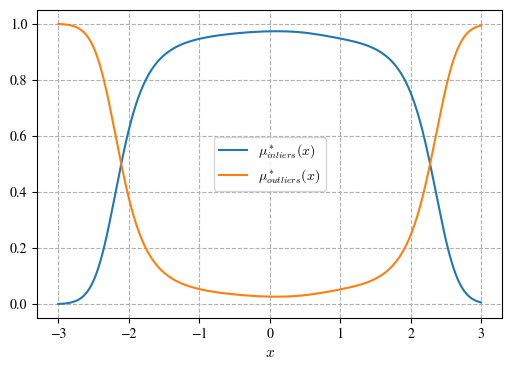

In [28]:
classifier = KDEClassification().fit(x_train, labels_pred)
scores = classifier.pdfs(x_grid)
scores *= classifier.prior

u_fuzzy = np.zeros(scores.shape)
mask = np.any(scores != 0, axis=1)
u_fuzzy[mask] = scores[mask] / scores[mask].sum(axis=1)[:, None]

# Plot
plt.figure(figsize=(6, 4), dpi=100)

plt.plot(x_grid, u_fuzzy)

plt.xlabel("$x$", fontsize=11)
legend = ["$\mu^*_{inliers}(x)$", "$\mu^*_{outliers}(x)$"]
plt.legend(legend, fontsize=10)
plt.grid(linestyle="--")
plt.show()

\newpage

### Wyniki w postaci intuicjonistycznej

Wyniki w postaci intuicjonistycznej do powyższego przykładu.

Procedura jak w przypadku klasyfikacji (etykietami są wyznaczone elementy typowe i nietypowe jako dwie klasy)

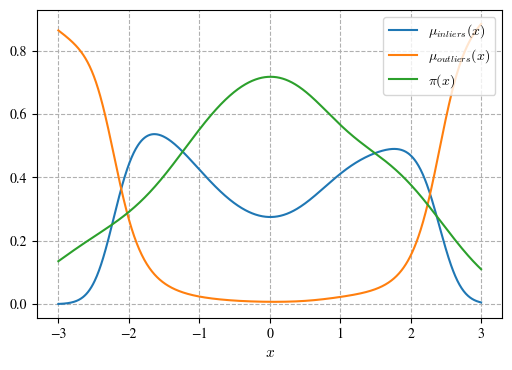

In [29]:
classifier = KDEClassification().fit(x_train, labels_pred)
labels_pred_tmp = classifier.predict(x_train)
mask_pred = labels_pred_tmp == labels_train
correctly_classified = np.sum(mask_pred)

if correctly_classified == 0:
    pi = np.full(x_grid.shape[0], 1)
elif correctly_classified == m_train:
    pi = np.full(x_grid.shape[0], 0)
else:
    x_train_good = x_train[mask_pred]
    x_train_bad = x_train[~mask_pred]

    kde_good = KDE().fit(x_train_good)
    kde_bad = KDE().fit(x_train_bad)

    scores_on_x_train_bad = kde_bad.pdf(x_train_bad)
    argmax_scores_on_x_train_bad = scores_on_x_train_bad.argmax()
    tmp_bad = kde_bad.pdf(x_train_bad[argmax_scores_on_x_train_bad][:, None])
    tmp_good = kde_good.pdf(x_train_bad[argmax_scores_on_x_train_bad][:, None])
    c = tmp_bad / (tmp_bad + tmp_good)

    scores_on_x = kde_bad.pdf(x_grid)
    pi = c * scores_on_x / scores_on_x_train_bad[argmax_scores_on_x_train_bad]

pi = np.sqrt(pi)
u_intuitionistic = (1 - pi[:, None]) * u_fuzzy

# Plot
plt.figure(figsize=(6, 4), dpi=100)

plt.plot(x_grid, u_intuitionistic)
plt.plot(x_grid, pi)

plt.xlabel("$x$", fontsize=11)
legend = ["$\mu_{inliers}(x)$", "$\mu_{outliers}(x)$", "$\pi(x)$"]
plt.legend(legend, fontsize=10)
plt.grid(linestyle="--")
plt.show()

\newpage

## Przykład 2

Przykład (2d) dla danych wygenerowanych z rozkładu Gaussa $N([0,0], [[1,0],[0,1]])$ przy: \
$seed=0$, $n=1$, $m=100$, $w_i=\frac{1}{m}$, jądro normalne, metoda przybliżona

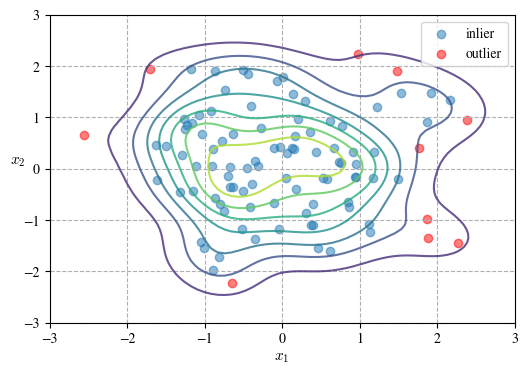

In [30]:
np.random.seed(0)


# Data
m_train = 100

cov = [[1.0, 0.0], [0.0, 1.0]]
x_train = np.random.multivariate_normal([0, 0], cov, m_train)


# Prepare 2d grid 
grid_size = 70
x1 = np.linspace(-3, 3, grid_size)
x2 = np.linspace(-3, 3, grid_size)
x1v, x2v = np.meshgrid(x1, x2)
x1p = x1v.reshape(-1, 1)
x2p = x2v.reshape(-1, 1)
x_grid = np.hstack((x1p, x2p))  # shape (4900, 2)


# KDE and Outliers Detector
kde = KDE().fit(x_train)
scores = kde.pdf(x_grid)

outliers_detector = KDEOutliersDetection().fit(x_train, r=0.1)
labels_pred = outliers_detector.predict(x_train)

outliers = labels_pred == 1
inliers = labels_pred == 0

# Plot
plt.figure(figsize=(6, 4), dpi=100)

plt.contour(x1v, x2v, scores.reshape(grid_size, grid_size), alpha=0.8)
plt.scatter(x_train[inliers, 0], x_train[inliers, 1], alpha=0.5, label="inlier")
plt.scatter(x_train[outliers, 0], x_train[outliers, 1], alpha=0.5, label="outlier", c="r")

plt.legend(fontsize=10)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel("$x_1$", fontsize=11)
plt.ylabel("$x_2$", fontsize=11, rotation=0)
plt.grid(linestyle="--")
plt.show()

In [31]:
print(f"Wskaźnik jakości [PI_kf]: {pi_kf(x_train, labels_pred):.3f}")

TypeError: pi_kf() missing 1 required positional argument: 'labels_test'

\newpage

# Klasteryzacja

$\color{red}{\text{Poniższe procedury przygotowane są tylko dla jądra normalnego.}}$


Procedura klasteryzacji składa się z dwóch zasadniczych kroków:

1. Przesunięcie wszystkich elementów zbioru do swoich najbliższych ekstremów (maksimów) lokalnych 
2. Przypisanie elementów zbioru do klastrów - przypisanie etykiet

___

1. Metody przesuwania elementów zbioru:
    * gradient ascent - metoda gradientowa
        $$ x_i^k = x_i^k + b * \frac{\nabla \hat{f}(x_i^k)}{\hat{f}(x_i^k)} $$
        $$ b = \frac{1}{n+2} h^2 $$
        * $n$ - wymiar
        * $k$ - kolejny krok optymalizacyjny (przesuwania elementu $x_i$)
        
        Przerywamy przesuwanie elementu w momencie, gdy odległość euklidesowa między $x_i^k$ i $x_i^{k+1}$ jest mniejsza od $\epsilon = 10^{-8}$

    * mean shift - oparta o punkt stały (fixed point theorem)
        $$ x_i^k = \frac{\sum_{i^{'}=1}^m w_i K(x_i^k,x_{i^{'}},h) x_{i^{'}}}{\sum_{i^{'}=1}^m w_i K(x_i^k,x_{i^{'}},h)} $$
        * $K(x)$ - jądro gaussowskie
        
        Przerywamy przesuwanie elementu w momencie, gdy odległość euklidesowa między $x_i^k$ i $x_i^{k+1}$ jest mniejsza od $\epsilon = 10^{-8}$

    $\color{red}{\text{Metoda mean shift lepiej sprawdza się w praktyce od gradient ascent}}$

2. Procedura przypisywania etykiet do przesuniętych elementów zbioru

    * Tworzymy pustą listę $rep$ dla reprezentantów wszystkich klastrów (ekstremów)
    * Bierzemy pierwszy element zbioru $x_1$ i wkładamy go do listry $rep$ uznając go za reprezentanta pierwszego klastra 
    * Iterujemy po pozostałych elementach zbioru od $i=2,3,...,m$ 
        * Iterujemy po elementach (reprezentantach) z listy $rep$ (indeks $j$)
            * Sprawdzamy czy odległość euklidesowa między elementem $x_i$ i reprezentantem $j$-tego klastra $rep_j$ jest mniejsza od $\delta=10^{-3}$.
            * Jeśli tak, to element $x_i$ należy do klastra $j$ (dostaje etykietę tego klastra) i przeskakujemy do kolejnego elementu zbioru $x$
            * Jeśli nie, to element $x_i$ nie należy do żadnego klastra z listy $rep$, w związku z tym dodajemy $x_i$ do listy $rep$ i staje się on teraz reprezentantem nowego klastra (dotychczas niewidzialnego w liście $rep$)
    * W ten sposób mamy przypisane etykiety klastrów do wszystkich elementów zbioru.

\newpage

## Źródła

* (Silverman, B. W. Density Estimation for Statistics and Data Analysis) - sekcja 6.1
* (Scott, Multivariate density estimation) - sekcja 9.2.4.2
* Menardi, G. Density-based Silhouette diagnostics for clustering methods
* Domanciu, D., Meer, P. Mean Shift: A robust approach toward feature space analysis
* Carreira, Fast Nonparametric SLutering with Gaussian Blurring Mean-shift
* Carreira, Generalised blurring mean-shift algorithms for nonparametric clustering
* Hinneburg, DENCLUE 2.0: Fast clustering based on kernel density estimation
* Carreira, A review of mean-shift algorithms for clustering

## Wskaźnik jakości

Density based Silhouette - gęstościowa wersja wskaźnika sylwetkowego.

DBS liczony dla każdego elementu $i$:

$$
dbs_i = \frac{\log{\frac{\tau_{c_0}(x_i)}{\tau_{c_1}(x_i)}}}{\underset{i^{'}=1,...,m}{\mathrm{max}} \; |\log{\frac{\tau_{c_0}(x_{i^{'}})}{\tau_{c_1}(x_{i^{'}})}}|}
$$

$$
\tau_c(x_i) = \frac{\pi_c \hat{f}_c(x_i)}{\sum_{k=1}^{n_C} \pi_k \hat{f}_k(x_i)}
$$

* $\tau_m(x_i)$ - prawdopodobieństwo a posteriori, że element $x_i$ należy do klastra $c$
* $c_0$ - klaster, do ktorego należy element $x_i$
* $c_1$ - najbliższy klaster w sensie gęstościowym, do ktorego nie należy element $x_i$

Notatka:

* dążymy do tego aby $\tau_{c_0}(x_i)$ było jak największe oraz aby $\tau_{c_1}(x_i)$ było jak najmniejsze
* wskaźnik $dbs$ maksymalizujemy

\newpage

## Przykład 1

Przykład jednowymiarowy na danych pochodzących z dwóch rozkładów normalnych $N(0, 1)$ oraz $N(5, 1)$ (przy równolicznym udziale) : \
$seed=0$, $n=1$, $m=100$, $w_i=\frac{1}{m}$, jądro normalne, metoda przybliżona, metoda gradientowa (gradient ascent), $\epsilon=10^{-8}$, $\delta=10^{-3}$

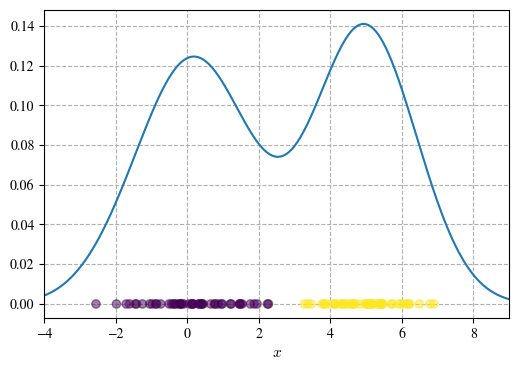

In [5]:
np.random.seed(0)

# Data
m_train = 100
n = 1
x_train1 = np.random.normal(0, 1, size=(m_train // 2, n))
x_train2 = np.random.normal(5, 1, size=(m_train // 2, n))
x_train = np.concatenate((x_train1, x_train2))

x_grid = np.linspace(-4, 9, 1000)[:, None]


# KDE and Clustering
kde = KDE().fit(x_train)
scores = kde.pdf(x_grid)

algorithm = "gradient_ascent"
epsilon = 1e-8
delta = 1e-3
clustering = KDEClustering().fit(x_train)
labels_pred = clustering.predict(x_train, algorithm, epsilon, delta)


# Plot
plt.figure(figsize=(6, 4), dpi=100)

plt.scatter(x_train[:, 0], x_train[:, 0] * 0, c=labels_pred, alpha=0.5, zorder=2)
plt.plot(x_grid, scores)

plt.xlabel("$x$", fontsize=11)
plt.xlim(-4, 9)
plt.grid(linestyle="--")
plt.show()

In [6]:
dbs, dbs_mean = density_silhouette(x_train, labels_pred)

print(f"mean dbs: {dbs_mean:.6f}")

mean dbs: 0.256202


\newpage

## Przykład 2

Przykład (2d) dla danych pochodzących z dwóch rozkładów normalnych $N([0,0], [[1,0],[0,1]])$ oraz $N([0,0], [[3,0],[0,3]])$ (przy równolicznym udziale) oraz: \
$seed=0$, $n=1$, $m=100$, $w_i=\frac{1}{m}$, jądro normalne, metoda przybliżona, metoda mean shift, $\epsilon=10^{-8}$, $\delta=10^{-3}$

Dodatkowo mamy tutaj porównanie z metodą k-means.

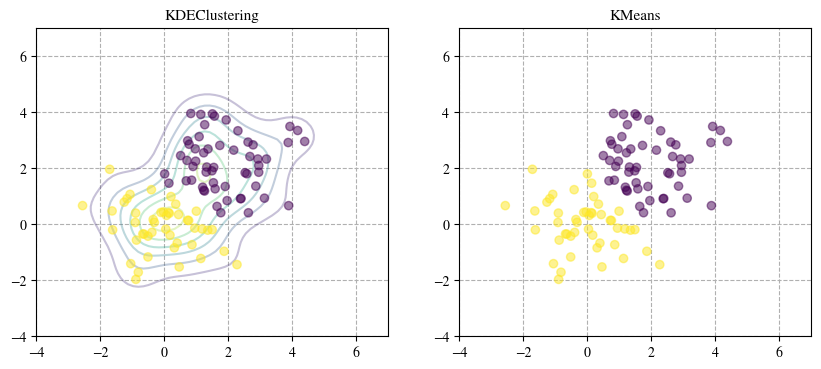

[KDEClustering] mean dbs: 0.248155
[KMeans] mean dbs: 0.240418


In [7]:
np.random.seed(0)

# Data
m_train = 100
n = 2
x_train1 = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], size=m_train // 2)
x_train2 = np.random.multivariate_normal([2, 2], [[1, 0], [0, 1]], size=m_train // 2)
x_train = np.concatenate((x_train1, x_train2))


# Prepare 2d grid 
grid_size = 70
x1 = np.linspace(-4, 7, grid_size)
x2 = np.linspace(-4, 7, grid_size)
x1v, x2v = np.meshgrid(x1, x2)
x1p = x1v.reshape(-1, 1)
x2p = x2v.reshape(-1, 1)
x_grid = np.hstack((x1p, x2p))  # shape (4900, 2)


# KDE and Clustering
kde = KDE().fit(x_train)
scores = kde.pdf(x_grid)

algorithm = "mean_shift"
epsilon = 1e-8
delta = 1e-3
clustering = KDEClustering().fit(x_train)
labels_pred1 = clustering.predict(x_train, algorithm, epsilon, delta)

# KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(x_train)
labels_pred2 = kmeans.predict(x_train)


# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

axs[0].contour(x1v, x2v, scores.reshape(grid_size, grid_size), alpha=0.3, zorder=2)
axs[0].scatter(x_train[:, 0], x_train[:, 1], c=labels_pred1, alpha=0.5, zorder=2)
axs[0].set_title("KDEClustering", fontsize=11)
axs[0].set_xlim(-4, 7)
axs[0].set_ylim(-4, 7)
axs[0].grid(linestyle="--")

axs[1].scatter(x_train[:, 0], x_train[:, 1], c=1 - labels_pred2, alpha=0.5, zorder=2)
axs[1].set_title("KMeans", fontsize=11)
axs[1].set_xlim(-4, 7)
axs[1].set_ylim(-4, 7)
axs[1].grid(linestyle="--")

plt.show()


# DBS
dbs1, dbs_mean1 = density_silhouette(x_train, labels_pred1)
dbs2, dbs_mean2 = density_silhouette(x_train, labels_pred2)
print(f"[KDEClustering] mean dbs: {dbs_mean1:.6f}")
print(f"[KMeans] mean dbs: {dbs_mean2:.6f}")

\newpage

## Przykład 3

Przykład (2d) dla danych "księżycowych" przy: \
$seed=0$, $n=1$, $m=100$, $w_i=\frac{1}{m}$, jądro normalne, metoda przybliżona, metoda mean shift, $\epsilon=10^{-8}$, $\delta=10^{-3}$

Dodatkowo mamy tutaj porównanie z metodą k-means.

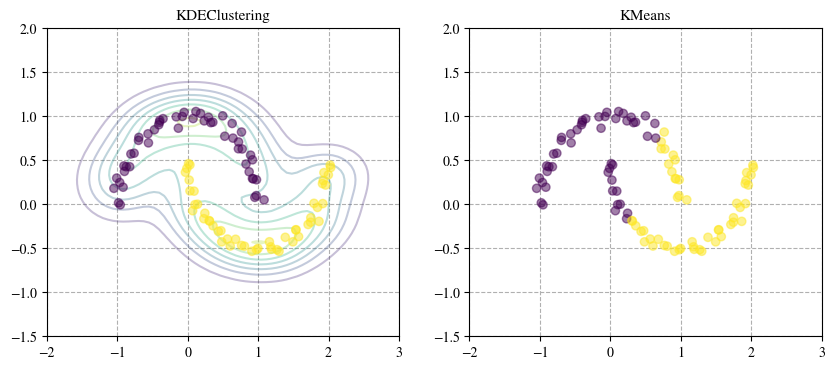

[KDEClustering] mean dbs: 0.567629
[KMeans] mean dbs: 0.402827


In [8]:
np.random.seed(0)

# Data
m_train = 100
x_train, _ = make_moons(n_samples=m_train, noise=0.05)


# Prepare 2d grid 
grid_size = 70
x1 = np.linspace(-2, 3, grid_size)
x2 = np.linspace(-1.5, 2, grid_size)
x1v, x2v = np.meshgrid(x1, x2)
x1p = x1v.reshape(-1, 1)
x2p = x2v.reshape(-1, 1)
x_grid = np.hstack((x1p, x2p))  # shape (4900, 2)


# KDE and Clustering
kde = KDE().fit(x_train)
scores = kde.pdf(x_grid)

algorithm = "mean_shift"
epsilon = 1e-8
delta = 1e-3
clustering = KDEClustering().fit(x_train)
labels_pred1 = clustering.predict(x_train, algorithm, epsilon, delta)

# KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(x_train)
labels_pred2 = kmeans.predict(x_train)


# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

axs[0].contour(x1v, x2v, scores.reshape(grid_size, grid_size), alpha=0.3, zorder=2)
axs[0].scatter(x_train[:, 0], x_train[:, 1], c=labels_pred1, alpha=0.5, zorder=2)
axs[0].set_title("KDEClustering", fontsize=11)
axs[0].set_xlim(-2, 3)
axs[0].set_ylim(-1.5, 2)
axs[0].grid(linestyle="--")

axs[1].scatter(x_train[:, 0], x_train[:, 1], c=1 - labels_pred2, alpha=0.5, zorder=2)
axs[1].set_title("KMeans", fontsize=11)
axs[1].set_xlim(-2, 3)
axs[1].set_ylim(-1.5, 2)
axs[1].grid(linestyle="--")

plt.show()


# DBS
dbs1, dbs_mean1 = density_silhouette(x_train, labels_pred1)
dbs2, dbs_mean2 = density_silhouette(x_train, labels_pred2)
print(f"[KDEClustering] mean dbs: {dbs_mean1:.6f}")
print(f"[KMeans] mean dbs: {dbs_mean2:.6f}")